In [39]:
# given a compatible train_valid_test.pt, this script will perform the baseline by treating each powerset as a class. 
# We know that it would not be perfect because the program will not get to infer labels for powersets it has not seen. 
# We will count the number of examples with those specified datasets
import Constants
import torch
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, confusion_matrix

def convert_tgt_seq_to_binary(data):
    def seq2binary(tgt_seq, num_labels, constants_values):
        tgt_binary = list()
        for i in range(len(tgt_seq)):
            y = np.zeros(num_labels)
            y[tgt_seq[i]] = 1
            y = np.delete(y, constants_values).astype(int)
            tgt_binary.append(y)
        return tgt_binary

    constants_dict = {Constants.UNK_WORD: Constants.UNK, Constants.EOS_WORD: Constants.EOS,
                        Constants.BOS_WORD: Constants.BOS, Constants.PAD_WORD: Constants.PAD}

    data['train']['tgt_binary'] = seq2binary(data['train']['tgt'], len(data['dict']['tgt']), list(constants_dict.values()))
    data['valid']['tgt_binary'] = seq2binary(data['valid']['tgt'], len(data['dict']['tgt']), list(constants_dict.values()))
    data['test']['tgt_binary'] = seq2binary(data['test']['tgt'], len(data['dict']['tgt']), list(constants_dict.values()))

    # update targets dictionary
    dict_y = data['dict']['tgt'].copy()
    for item in data['dict']['tgt']:
        if item in constants_dict:
            dict_y.pop(item)
        else:
            dict_y[item] = dict_y[item] - len(constants_dict)
    data['dict']['tgt'] = dict_y

    return data

def vectorize_sequence(sequences,dimensions):
    results=np.zeros((len(sequences),dimensions))
    for i, sequence in enumerate(sequences):
        results[i,sequence] = 1.
    return results

data = torch.load('train_valid_test.pt')
data = convert_tgt_seq_to_binary(data)
# get features
x_train=vectorize_sequence(data['train']['src'],len(data['dict']['src']))
x_test=vectorize_sequence(data['test']['src'],len(data['dict']['src']))
# get target
y_train=np.array(data['train']['tgt_binary'])
y_test=np.array(data['test']['tgt_binary'])




In [32]:
unq_rows, count = np.unique(y_train,axis=0, return_counts=1)
len(unq_rows)

461

In [40]:
def partition(array):
    return {tuple(row): i for i, row in enumerate(np.unique(array, axis=0))}
unique_dict = partition(y_train)
# change y_train to label power sets
print(x_train.shape)
print(y_train.shape)

(2400, 47236)
(2400, 101)


In [42]:

binary_class = False
if binary_class:
    train_sc = []
    test_sc = []
    pred_train = np.zeros(y_train.shape)
    pred_test = np.zeros(y_test.shape)
    for i in range(101):
        mnb = MultinomialNB().fit(x_train, y_train[:, i])
        score_test = mnb.score(x_test, y_test[:,i])
        score_train = mnb.score(x_train, y_train[:,i])
        test_sc.append(score_test)
        train_sc.append(score_train)
        pred_train[:,i] = mnb.predict(x_train)
        pred_test[:,i] = mnb.predict(x_test)
        print("score on test: " + str(score_test))
        print("score on train: "+ str(score_train))
        print("f1 on test: " + str(f1_score(y_test[:,i], pred_test[:,i])))
        print("f1 on train: " + str(f1_score(y_train[:,i], pred_train[:,i])))
        print(confusion_matrix(y_test[:,i], pred_test[:,i]))
        print(confusion_matrix(y_train[:,i], pred_train[:,i]))
else:
    # change y_train to label power sets
    y_train_power = np.zeros(len(y_train))
    y_test_power = np.zeros(len(y_test))
    count = 0
    for i in range(len(y_train)):
        y_train_power[i] = unique_dict[tuple(y_train[i])]
        if (tuple(y_test[i]) in unique_dict):
            y_test_power[i] = unique_dict[tuple(y_test[i])]
        else:
            y_test_power[i] = 0
            count+=1
    mnb = MultinomialNB().fit(x_train, y_train_power)
    power_pred_train = mnb.predict(x_train)
    power_pred_test = mnb.predict(x_test)
    score_test = mnb.score(x_test, y_test_power)
    score_train = mnb.score(x_train, y_train_power)
    print("score on test: " + str(score_test))
    print("score on train: "+ str(score_train))

score on test: 0.30333333333333334
score on train: 0.44416666666666665


In [47]:
y_train.shape

(2400, 101)

In [59]:
count = 0
for i in range(len(power_pred_train)):
    if(power_pred_train[i]==y_train_power[i]):
        for labels, index in unique_dict.items():
            if (index==power_pred_train[i]):
                print(labels)
                count+=1
    if(count>5):
        break           
    

(0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
(0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

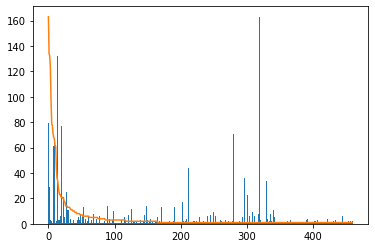

In [72]:

import numpy as np
import matplotlib.pyplot as plt
plt.plot(np.sort(plt.hist(y_train_power, bins=np.arange(y_train_power.min(), y_train_power.max()+1))[0])[::-1])

In [5]:
co_matrix = np.matmul(y_train.T, y_train)

In [23]:
import matplotlib.pyplot as plt
label_occur_vector = y_train.sum(axis=0)
adjusted_co_matrix = co_matrix / label_occur_vector
np.count_nonzero(adjusted_co_matrix==1)
#plt.matshow(adjusted_co_matrix, aspect='auto')
#plt.colorbar()

c:\users\david\anaconda3\envs\graphenv\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


261

In [63]:
# find subset accuracy
def subset_accuracy(pred, y):
    count = 0
    for i in range(len(pred)):
        if (np.array_equal(pred[i], y[i])):
            count = count + 1
    print(count/len(pred))
subset_accuracy(pred_train[:,0:50],y_train[:, 0:50])
subset_accuracy(pred_test[:,0:50], y_test[:,0:50])

0.4658333333333333
0.4696666666666667


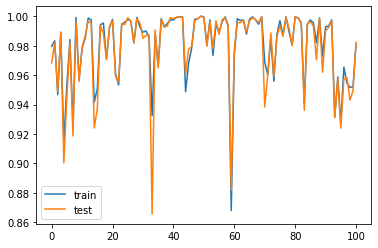

In [70]:
import matplotlib.pyplot as plt
x = np.arange(101)
plt.plot(x,train_sc,label='train')
plt.plot(x,test_sc,label='test')
plt.legend()
plt.show()

In [72]:
x = np.array([1,2,3])
tuple(x)

(1, 2, 3)